In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D


In [2]:
from tensorflow.keras.optimizers import Adam # - Works
import random
from glob import glob
import seaborn as sns
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import matplotlib.pyplot as plt
import matplotlib.image as img
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

DATA Preprocessing

In [3]:
data_dir_train=pathlib.Path("E:\Code_playground\Skin Cancer\ISIC Model\Skin cancer ISIC The International Skin Imaging Collaboration\Train")
data_dir_test = pathlib.Path("E:\Code_playground\Skin Cancer\ISIC Model\Skin cancer ISIC The International Skin Imaging Collaboration\Test")

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [5]:
batch_size = 32
img_height = 180
img_width = 180
rnd_seed = 123
random.seed(rnd_seed)

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  validation_split=0.9,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.
Found 118 files belonging to 9 classes.
Using 106 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


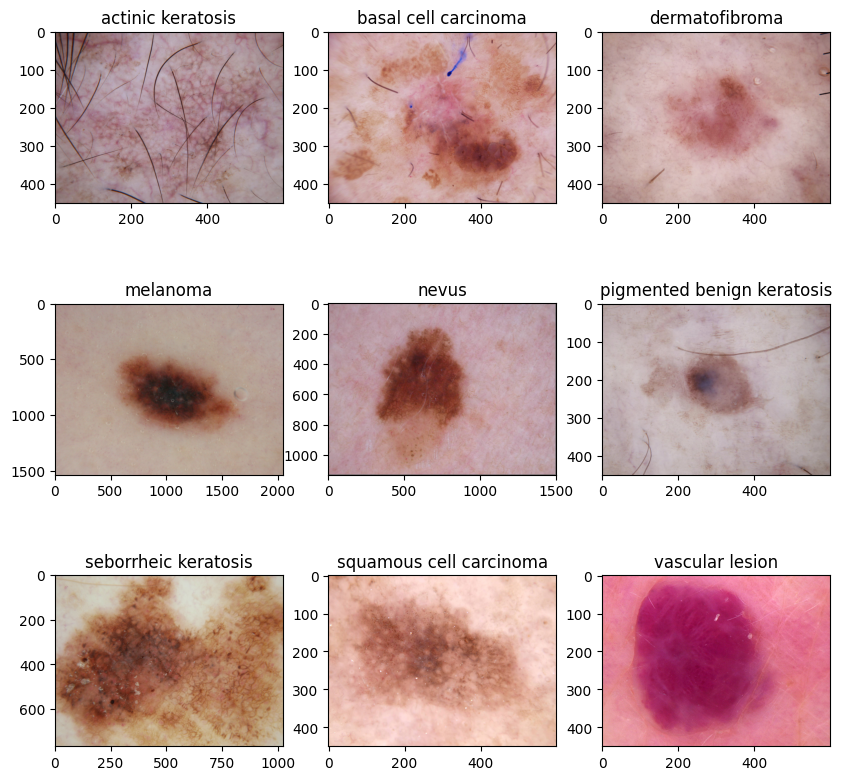

In [8]:
num_classes = len(class_names)
plt.figure(figsize=(10,10))
for i in range(num_classes):
  plt.subplot(3,3,i+1)
  image = img.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

In [9]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 180, 180, 3)
(32,)


In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Creating CNN Layers

In [11]:
num_classes = 9
model = Sequential([layers.experimental.preprocessing.Rescaling \
                    (1.0/255,input_shape=(img_height,img_width,3))])

model.add(Conv2D(32, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(64, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(128, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(256, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(512, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Flatten())
model.add(Dense(1024,activation="relu"))
model.add(Dense(units=num_classes, activation= 'softmax'))

In [12]:
opt = Adam(lr=0.001)
model.compile(optimizer= opt,loss= SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 128)       7

In [14]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=15
)

Epoch 1/15


56/56 [==============================] - 210s 3s/step - loss: 2.0021 - accuracy: 0.2416 - val_loss: 1.9110 - val_accuracy: 0.2953
Epoch 2/15
56/56 [==============================] - 95s 2s/step - loss: 1.7500 - accuracy: 0.3382 - val_loss: 1.7239 - val_accuracy: 0.3826
Epoch 3/15
56/56 [==============================] - 94s 2s/step - loss: 1.6854 - accuracy: 0.3945 - val_loss: 1.5762 - val_accuracy: 0.4228
Epoch 4/15
56/56 [==============================] - 93s 2s/step - loss: 1.5728 - accuracy: 0.4263 - val_loss: 1.5669 - val_accuracy: 0.4295
Epoch 5/15
56/56 [==============================] - 89s 2s/step - loss: 1.4877 - accuracy: 0.4760 - val_loss: 1.4705 - val_accuracy: 0.5078
Epoch 6/15
56/56 [==============================] - 91s 2s/step - loss: 1.3876 - accuracy: 0.5123 - val_loss: 1.5006 - val_accuracy: 0.4899
Epoch 7/15
56/56 [==============================] - 90s 2s/step - loss: 1.3576 - accuracy: 0.5218 - val_loss: 1.4351 - val_accuracy: 0.5347
Epoch 8/15
56/56 [============

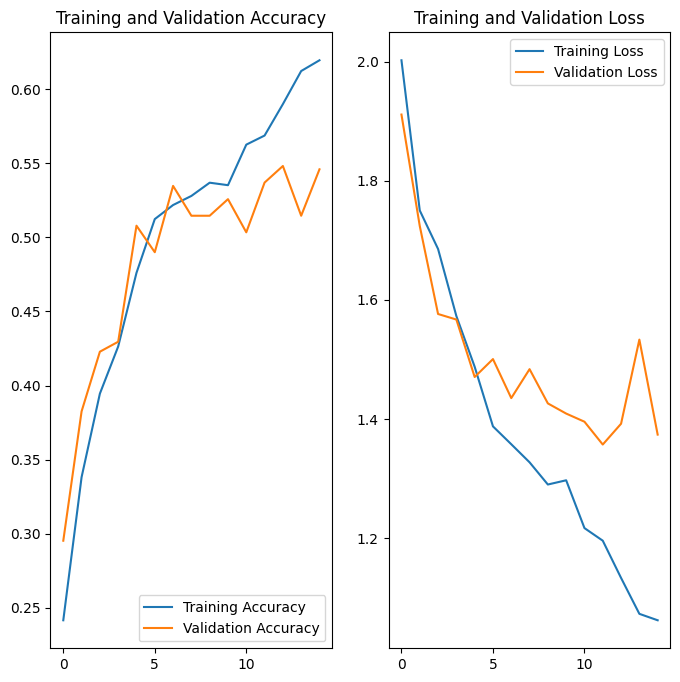

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Model 2 : Data Augumentation with drop out layer.

In [11]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", input_shape=(img_height,img_width,3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
  ]
)

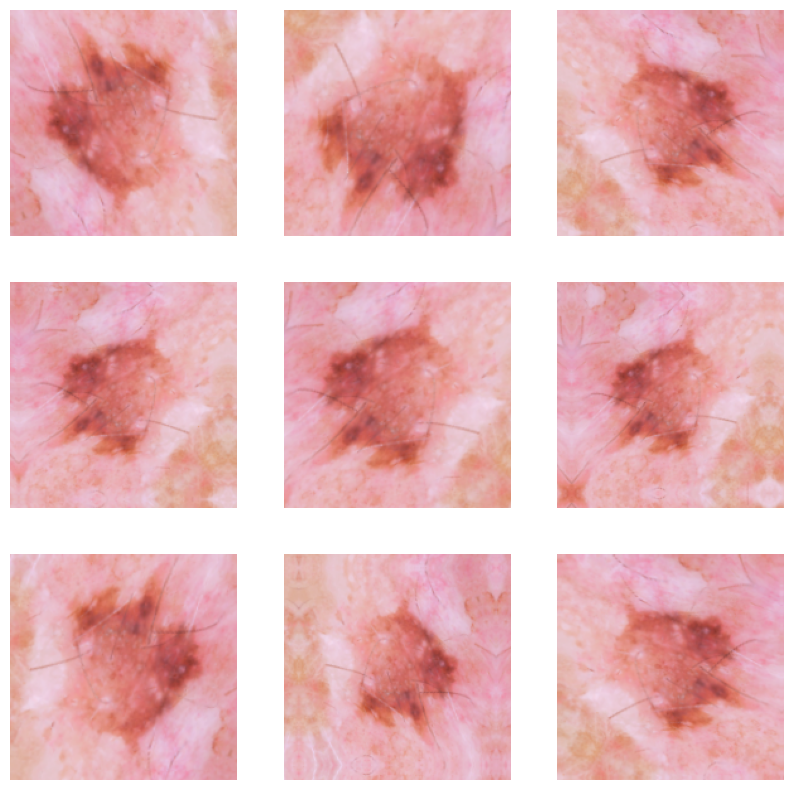

In [12]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [17]:
num_classes = 9
model = Sequential(data_augmentation)
model.add(layers.experimental.preprocessing.Rescaling(1.0/255,input_shape=(img_height,img_width,3)))

model.add(Conv2D(32, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(64, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(128, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.15))

model.add(Conv2D(256, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.20))

model.add(Conv2D(512, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024,activation="relu"))
model.add(Dense(units=num_classes, activation= 'softmax'))

In [17]:
opt = Adam(lr=0.001)
model.compile(optimizer=opt,loss= SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

NameError: name 'model' is not defined

In [ ]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=25
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [13]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, optimizers

Augmentor : Class balance

In [14]:
import os
output_directory = os.getcwd() + '/augmented_images/'

In [15]:
# List all directories (classes) in the data directory
class_names = os.listdir(data_dir_train)

# Iterate through each class and count the number of images
for class_name in class_names:
    class_path = os.path.join(data_dir_train, class_name)
    if os.path.isdir(class_path):  # Check if it's a directory
        num_images = len(os.listdir(class_path))
        print(f'Class: {class_name}, Number of Images: {num_images}')

Class: actinic keratosis, Number of Images: 114
Class: basal cell carcinoma, Number of Images: 376
Class: dermatofibroma, Number of Images: 95
Class: melanoma, Number of Images: 438
Class: nevus, Number of Images: 357
Class: pigmented benign keratosis, Number of Images: 462
Class: seborrheic keratosis, Number of Images: 77
Class: squamous cell carcinoma, Number of Images: 181
Class: vascular lesion, Number of Images: 139


In [16]:
import Augmentor
import os
import pathlib

# Define the path to the training dataset
path_to_training_dataset = pathlib.Path(r'E:\Code_playground\Skin Cancer\ISIC Model\Skin cancer ISIC The International Skin Imaging Collaboration\Train')
output_directory = os.getcwd() + '/data/'

# Convert class_names to a list if it's not already
class_names = list(class_names)

# Iterate through each class and create Augmentor pipeline
for i in class_names:
    p = Augmentor.Pipeline(str(path_to_training_dataset / i), output_directory=str(output_directory + i + '/output/'))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to e:\Code_playground\Skin Cancer\ISIC Model\Skin cancer ISIC The International Skin Imaging Collaboration/data/actinic keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1CEC0F03730>: 100%|██████████| 500/500 [00:15<00:00, 32.75 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to e:\Code_playground\Skin Cancer\ISIC Model\Skin cancer ISIC The International Skin Imaging Collaboration/data/basal cell carcinoma/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1CEC0F986A0>: 100%|██████████| 500/500 [00:09<00:00, 51.66 Samples/s]


Initialised with 95 image(s) found.
Output directory set to e:\Code_playground\Skin Cancer\ISIC Model\Skin cancer ISIC The International Skin Imaging Collaboration/data/dermatofibroma/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1CEC10AE4A0>: 100%|██████████| 500/500 [00:14<00:00, 34.62 Samples/s] 


Initialised with 438 image(s) found.
Output directory set to e:\Code_playground\Skin Cancer\ISIC Model\Skin cancer ISIC The International Skin Imaging Collaboration/data/melanoma/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=722x542 at 0x1CEC0F4B760>: 100%|██████████| 500/500 [01:10<00:00,  7.11 Samples/s]  


Initialised with 357 image(s) found.
Output directory set to e:\Code_playground\Skin Cancer\ISIC Model\Skin cancer ISIC The International Skin Imaging Collaboration/data/nevus/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1CEC0EB22F0>: 100%|██████████| 500/500 [01:05<00:00,  7.66 Samples/s]  


Initialised with 462 image(s) found.
Output directory set to e:\Code_playground\Skin Cancer\ISIC Model\Skin cancer ISIC The International Skin Imaging Collaboration/data/pigmented benign keratosis/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1CEC0EC91B0>: 100%|██████████| 500/500 [00:14<00:00, 34.21 Samples/s] 


Initialised with 77 image(s) found.
Output directory set to e:\Code_playground\Skin Cancer\ISIC Model\Skin cancer ISIC The International Skin Imaging Collaboration/data/seborrheic keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1CEC3ECA920>: 100%|██████████| 500/500 [00:29<00:00, 16.77 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to e:\Code_playground\Skin Cancer\ISIC Model\Skin cancer ISIC The International Skin Imaging Collaboration/data/squamous cell carcinoma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1CEC3D3E650>: 100%|██████████| 500/500 [00:10<00:00, 48.87 Samples/s]                   


Initialised with 139 image(s) found.
Output directory set to e:\Code_playground\Skin Cancer\ISIC Model\Skin cancer ISIC The International Skin Imaging Collaboration/data/vascular lesion/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1CEC3E8FD90>: 100%|██████████| 500/500 [00:10<00:00, 47.22 Samples/s]                  


In [17]:
output_dir = pathlib.Path(output_directory)  # Convert output directory to a Path object
image_count_train = len(list(output_dir.glob('*/output/*.jpg')))
print(image_count_train)

18000


total training image count = 18000 

-------------------------------------
Class name =  actinic keratosis
count      =  2000
proportion =  0.1111111111111111
-------------------------------------
Class name =  basal cell carcinoma
count      =  2000
proportion =  0.1111111111111111
-------------------------------------
Class name =  dermatofibroma
count      =  2000
proportion =  0.1111111111111111
-------------------------------------
Class name =  melanoma
count      =  2000
proportion =  0.1111111111111111
-------------------------------------
Class name =  nevus
count      =  2000
proportion =  0.1111111111111111
-------------------------------------
Class name =  pigmented benign keratosis
count      =  2000
proportion =  0.1111111111111111
-------------------------------------
Class name =  seborrheic keratosis
count      =  2000
proportion =  0.1111111111111111
-------------------------------------
Class name =  squamous cell carcinoma
count      =  2000
proportion =  0.1111111

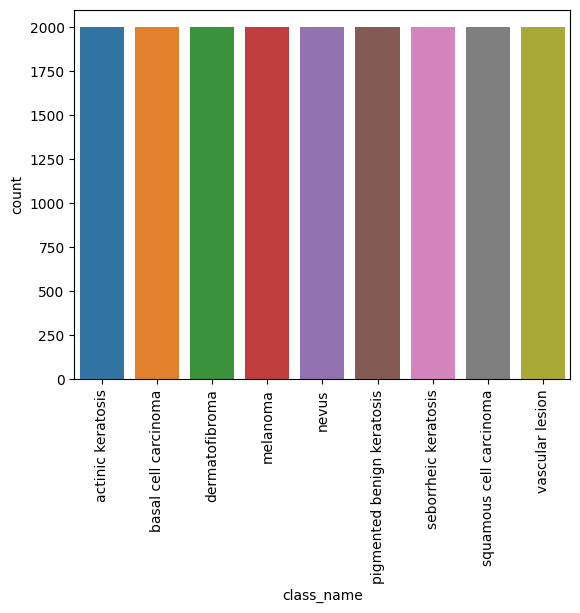

In [18]:
num_classes = len(class_names)
total = 0
all_count = []
class_name = []

for i in range(num_classes):
  count = len(list(output_dir.glob(class_names[i]+'/output/*.jpg')))
  total += count
print("total training image count = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
  count = len(list(output_dir.glob(class_names[i]+'/output/*.jpg')))
  print("Class name = ",class_names[i])
  print("count      = ",count)
  print("proportion = ",count/total)
  print("-------------------------------------")
  all_count.append(count)
  class_name.append(class_names[i])
temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()

Model 3 : Model with Class balance data.

In [19]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 18000 files belonging to 9 classes.
Using 14400 files for training.


In [20]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 18000 files belonging to 9 classes.
Using 3600 files for validation.


In [21]:
print(train_ds.class_names)


['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [32]:
num_classes = 9
model = Sequential([layers.experimental.preprocessing.Rescaling(1.0/255,input_shape=(img_height,img_width,3))])

model.add(Conv2D(32, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(64, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(128, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.15))

model.add(Conv2D(256, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.20))

model.add(Conv2D(512, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024,activation="relu"))
model.add(Dense(units=num_classes, activation= 'softmax'))

In [33]:
opt = Adam(lr=0.001)
model.compile(optimizer= opt,loss = SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [ ]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=25
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


Model : Transefer learning Model

RESNET50


In [16]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, optimizers

In [17]:
resnet_model = Sequential()

pretrained_model= keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(180,180,3),
    pooling='max',
    classes=9,
    classifier_activation="softmax",
)

for layer in pretrained_model.layers:
    layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(1024, activation='relu'))
resnet_model.add(Dense(9, activation='softmax'))

In [18]:
# Compile the model
opt = optimizers.Adam(lr=0.001)
resnet_model.compile(optimizer=opt,loss='sparse_categorical_crossentropy',  # Use sparse categorical crossentropy for integer labels
              metrics=['accuracy'])

In [19]:
history = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10


56/56 [==============================] - 240s 4s/step - loss: 6.2969 - accuracy: 0.3605 - val_loss: 1.7174 - val_accuracy: 0.4541
Epoch 2/10
56/56 [==============================] - 141s 3s/step - loss: 1.1865 - accuracy: 0.5887 - val_loss: 1.2688 - val_accuracy: 0.5615
Epoch 3/10
56/56 [==============================] - 122s 2s/step - loss: 0.8816 - accuracy: 0.6881 - val_loss: 1.3657 - val_accuracy: 0.5682
Epoch 4/10
56/56 [==============================] - 127s 2s/step - loss: 0.7137 - accuracy: 0.7522 - val_loss: 1.3642 - val_accuracy: 0.5548
Epoch 5/10
56/56 [==============================] - 125s 2s/step - loss: 0.5714 - accuracy: 0.8103 - val_loss: 1.3170 - val_accuracy: 0.6107
Epoch 6/10
56/56 [==============================] - 124s 2s/step - loss: 0.4839 - accuracy: 0.8421 - val_loss: 1.3756 - val_accuracy: 0.5570
Epoch 7/10
56/56 [==============================] - 123s 2s/step - loss: 0.4055 - accuracy: 0.8477 - val_loss: 1.3366 - val_accuracy: 0.6018
Epoch 8/10
56/56 [======

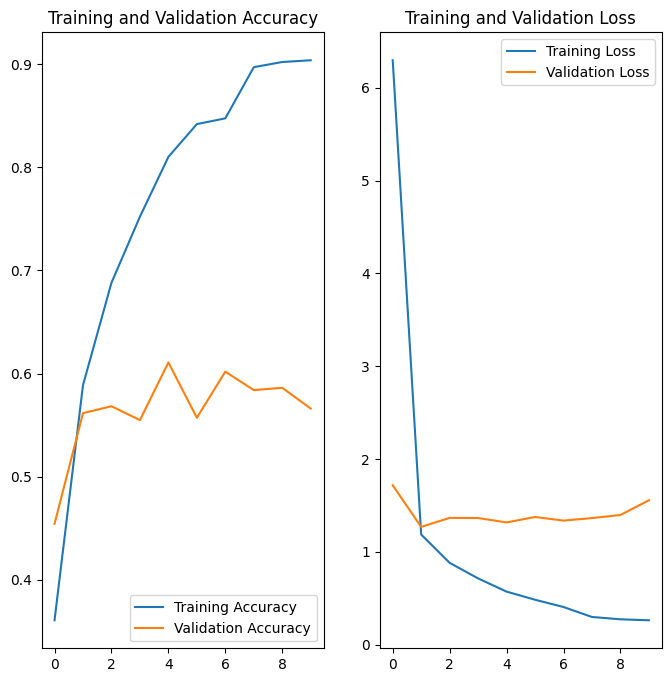

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Load and preprocess the image
image_path = r'C:\Users\Sakshi\OneDrive\Desktop\Skin Data\Skin cancer ISIC The International Skin Imaging Collaboration\Train\melanoma\ISIC_0000299.jpg'  # Replace with the path to your image
img = load_img(image_path, target_size=(180, 180))  # Adjust target_size based on your model's input shape
img = img_to_array(img)
img = np.expand_dims(img, axis=0)

# Make a prediction using the skin cancer classification model
prediction = resnet_model.predict(img)

# Debugging information
print("Shape of prediction array:", prediction.shape)
print("Prediction array:", prediction)

# Determine the class label based on the prediction
class_labels = ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']

# Check if the prediction shape matches the number of classes
if prediction.shape[-1] == len(class_labels):
    class_label = class_labels[np.argmax(prediction)]
    print(f"Predicted class: {class_label}")
else:
    print("Number of classes in prediction does not match the number of class labels.")

In [ ]:
import matplotlib.pyplot as plt

# Load the actual image
actual_img = load_img(image_path, target_size=(180, 180))  # Load the original image

# Plot the actual image
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.imshow(actual_img)
plt.title(f"Actual Image: {class_label}")
plt.axis('off')

# Plot the predicted image
plt.subplot(1, 2, 2)
plt.imshow(img[0].astype('uint8'))  # Convert to uint8 for imshow
plt.title(f"Predicted: {class_label}")
plt.axis('off')

# Show the plot
plt.show()

#### Inception V3

In [21]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers

In [22]:
base_model = InceptionV3(weights='imagenet', include_top=False)

# Add a global average pooling layer and a dense layer for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(9, activation='softmax')(x)

In [23]:
Inception_model = Model(inputs=base_model.input, outputs=predictions)

In [24]:
# Compile the model
opt = optimizers.Adam(lr=0.001)
base_model.compile(optimizer=opt,loss='sparse_categorical_crossentropy',  # Use sparse categorical crossentropy for integer labels
              metrics=['accuracy'])

In [25]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [26]:
validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

In [27]:
train_generator = train_datagen.flow_from_directory(
    data_dir_train,
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

Found 2239 images belonging to 9 classes.


In [28]:
test_generator = validation_datagen.flow_from_directory(
    data_dir_test,
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 118 images belonging to 9 classes.


In [29]:
Inception_model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

In [1]:
from tensorflow.keras.callbacks import LambdaCallback

print_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: print(
        f"Epoch: {epoch+1}, Loss: {logs['loss']:.4f}, Accuracy: {logs['accuracy']:.4f}, Val Loss: {logs['val_loss']:.4f}, Val Accuracy: {logs['val_accuracy']:.4f}, LR: {model.optimizer.lr.numpy():.4f}"
    )
)

In [31]:
Inception_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    epochs=10
)

Epoch 1/10
69/69 [==============================] - 982s 14s/step - loss: 0.3173 - accuracy: 0.3226 - val_loss: 978.5641 - val_accuracy: 0.1667
Epoch 2/10
 1/69 [..............................] - ETA: 15:55 - loss: 0.2728 - accuracy: 0.4062

KeyboardInterrupt: 

#### Hybrid Model (Inceptio V3 + DenseNet)

In [32]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3, DenseNet121
from tensorflow.keras.layers import Concatenate, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

In [61]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import InceptionV3, DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Concatenate, GlobalAveragePooling2D, Dense, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import os

In [62]:
# Function to load and preprocess images
def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array /= 255.0  # Normalize pixel values to [0, 1]
    return img_array

In [54]:
# Load dataset from train and test folders
def load_dataset(train_dir, test_dir, num_samples=None):
    train_X = []
    train_y = []
    test_X = []
    test_y = []

    for class_name in os.listdir(train_dir):
        class_dir = os.path.join(train_dir, class_name)
        if os.path.isdir(class_dir):
            train_images = os.listdir(class_dir)
            for image_name in train_images[:num_samples]:
                image_path = os.path.join(class_dir, image_name)
                train_X.append(preprocess_image(image_path))
                train_y.append(class_name)

    for class_name in os.listdir(test_dir):
        class_dir = os.path.join(test_dir, class_name)
        if os.path.isdir(class_dir):
            test_images = os.listdir(class_dir)
            for image_name in test_images[:num_samples]:
                image_path = os.path.join(class_dir, image_name)
                test_X.append(preprocess_image(image_path))
                test_y.append(class_name)

    return np.array(train_X), np.array(train_y), np.array(test_X), np.array(test_y)


In [55]:
train_dir=pathlib.Path("E:\Code_playground\Skin Cancer\ISIC Model\Skin cancer ISIC The International Skin Imaging Collaboration\Train")
test_dir= pathlib.Path("E:\Code_playground\Skin Cancer\ISIC Model\Skin cancer ISIC The International Skin Imaging Collaboration\Test")

In [56]:
X_train, y_train, X_test, y_test = load_dataset(train_dir, test_dir)

In [57]:
# Convert class labels to one-hot encoding
class_labels = np.unique(y_train)
label_map = {label: idx for idx, label in enumerate(class_labels)}
y_train = [label_map[label] for label in y_train]
y_test = [label_map[label] for label in y_test]
y_train = to_categorical(y_train, num_classes=len(class_labels))
y_test = to_categorical(y_test, num_classes=len(class_labels))

In [58]:
# Load InceptionV3 and DenseNet models
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
densenet_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [59]:
# Freeze layers in both models
for layer in inception_model.layers:
    layer.trainable = False

for layer in densenet_model.layers:
    layer.trainable = False

In [63]:
# Global average pooling layers
inception_gap = GlobalAveragePooling2D()(inception_model.output)
densenet_gap = GlobalAveragePooling2D()(densenet_model.output)

In [64]:
# Concatenate the output features from both models
concatenated_output = Concatenate()([inception_gap, densenet_gap])

In [65]:
# Additional dense layers for classification
output = Dense(512, activation='relu')(concatenated_output)
output = Dense(len(class_labels), activation='softmax')(output)

In [66]:
# Create concatenated model
concatenated_model = Model(inputs=[inception_model.input, densenet_model.input], outputs=output)

In [67]:
# Compile the model
concatenated_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [68]:
# Train the model
concatenated_model.fit([X_train, X_train], y_train, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
63/63 [==============================] - 296s 5s/step - loss: 1.9031 - accuracy: 0.4025 - val_loss: 6.8727 - val_accuracy: 0.0000e+00
Epoch 2/10
63/63 [==============================] - 264s 4s/step - loss: 1.2427 - accuracy: 0.5543 - val_loss: 8.1697 - val_accuracy: 0.0312
Epoch 3/10
63/63 [==============================] - 288s 5s/step - loss: 1.0352 - accuracy: 0.6422 - val_loss: 8.7810 - val_accuracy: 0.1116
Epoch 4/10
63/63 [==============================] - 264s 4s/step - loss: 0.8978 - accuracy: 0.6834 - val_loss: 9.6232 - val_accuracy: 0.0982
Epoch 5/10
47/63 [=====================>........] - ETA: 1:08 - loss: 0.7794 - accuracy: 0.7274

KeyboardInterrupt: 

With Callbacks

In [ ]:
# Define callbacks
checkpoint = ModelCheckpoint("concatenated_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)


In [ ]:
# Callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

callback = [reduce_lr, early_stopping, checkpoint]

In [ ]:
# Train the model
concatenated_model.fit([X_train, X_train], y_train, epochs=10, batch_size=32, validation_split=0.1, callbacks=callback)

In [ ]:
# Evaluate the model
y_pred = np.argmax(concatenated_model.predict([X_test, X_test]), axis=1)
y_true = np.argmax(y_test, axis=1)
accuracy = accuracy_score(y_true, y_pred)
print("Test Accuracy:", accuracy)

MobileNet

In [33]:
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2

In [34]:
# Load MobileNetV2 model
mobilenet_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


In [35]:
# Freeze layers in the MobileNetV2 model
for layer in mobilenet_model.layers:
    layer.trainable = False

In [ ]:
# Global average pooling layer
mobilenet_gap = GlobalAveragePooling2D()(mobilenet_model.output)

In [ ]:
# Additional dense layers for classification
output = Dense(512, activation='relu')(mobilenet_gap)
output = Dense(len(class_labels), activation='softmax')(output)

# Create MobileNetV2 model
mobilenet_model_custom = Model(inputs=mobilenet_model.input, outputs=output)

In [ ]:
# Compile the model
mobilenet_model_custom.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
mobilenet_model_custom.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

DenseNet121

In [45]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [28]:
# Load the pre-trained DenseNet121 model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

In [29]:
# Add a classification head to the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)

In [32]:
# Define the model
Dense_model = Model(inputs=base_model.input, outputs=predictions)

In [34]:
# Compile the model
Dense_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [46]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [50]:
batch_size = 32
epochs = 10

# Define the training and validation data generators
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    data_dir_train,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)
val_generator = val_datagen.flow_from_directory(
    data_dir_test,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


In [51]:
# Train the model
Dense_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint(filepath='densenet.h5', monitor='val_loss', save_best_only=True)
    ]
)

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node 'categorical_crossentropy/softmax_cross_entropy_with_logits' defined at (most recent call last):
    File "c:\Users\abhis\anaconda3\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\abhis\anaconda3\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\abhis\anaconda3\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\abhis\anaconda3\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "c:\Users\abhis\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 711, in start
      self.io_loop.start()
    File "c:\Users\abhis\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\abhis\anaconda3\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\abhis\anaconda3\lib\asyncio\base_events.py", line 1906, in _run_once
      handle._run()
    File "c:\Users\abhis\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\abhis\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\abhis\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\abhis\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\abhis\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "c:\Users\abhis\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "c:\Users\abhis\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\abhis\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "c:\Users\abhis\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "c:\Users\abhis\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\abhis\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\abhis\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\abhis\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\abhis\AppData\Local\Temp\ipykernel_13236\461405695.py", line 2, in <module>
      Dense_model.fit(
    File "c:\Users\abhis\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\abhis\anaconda3\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\abhis\anaconda3\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\abhis\anaconda3\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\abhis\anaconda3\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\abhis\anaconda3\lib\site-packages\keras\engine\training.py", line 994, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\abhis\anaconda3\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
      return self.compiled_loss(
    File "c:\Users\abhis\anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\abhis\anaconda3\lib\site-packages\keras\losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "c:\Users\abhis\anaconda3\lib\site-packages\keras\losses.py", line 272, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\abhis\anaconda3\lib\site-packages\keras\losses.py", line 1990, in categorical_crossentropy
      return backend.categorical_crossentropy(
    File "c:\Users\abhis\anaconda3\lib\site-packages\keras\backend.py", line 5535, in categorical_crossentropy
      return tf.nn.softmax_cross_entropy_with_logits(
Node: 'categorical_crossentropy/softmax_cross_entropy_with_logits'
logits and labels must be broadcastable: logits_size=[32,7] labels_size=[32,9]
	 [[{{node categorical_crossentropy/softmax_cross_entropy_with_logits}}]] [Op:__inference_train_function_52229]